## ACTD 2024 - 20

### Clases 13-14: redes neuronales para clasificación

- Redes densas
- Redes para clasificación
- Procesamiento de datos continuos y categóricos
- Funciones de activación y pérdida

Empecemos importando numpy, pandas, keras, tensorflow

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

2024-09-30 20:37:52.860422: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Carguemos el archivo auto-mpg.data (disponible en Bloque Neón) usando pandas. Note que debemos incluir los nombres de las columnas, además de indicar los caracteres para separación, nas y comentarios.

In [2]:
df = pd.read_csv('heart.csv')

Exploremos las primeras filas del dataframe.

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


Descripción de las variables:

https://archive.ics.uci.edu/dataset/45/heart+disease


Exploremos el tamaño del df

In [4]:
df.shape

(303, 14)

Identificamos NAs en los datos

In [5]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Definimos listas para las variables categóricas enteras, categóricas string y numéricas.

In [6]:
## Reducimos el numero de variables categoricas a 4
cat_int_feats = ['sex', 'cp', 'fbs', 'exang']

In [7]:
cat_str_feats = ['thal']

In [8]:
# Reducimos el numero de variables numericas a 4
num_feats = ['age', 'chol', 'oldpeak', 'slope']

Agregamos las listas de categorías

In [9]:
feats_ordered = cat_int_feats+cat_str_feats+num_feats

Reordenamos el dataframe de acuerdo con el tipo de variable

In [10]:
df = df[feats_ordered+['target']]

In [11]:
df.head()

,sex,cp,fbs,exang,thal,age,chol,oldpeak,slope,target
0,1,1,1,0,fixed,63,233,2.3,3,0
1,1,4,0,1,normal,67,286,1.5,2,1
2,1,4,0,1,reversible,67,229,2.6,2,0
3,1,3,0,0,normal,37,250,3.5,3,0
4,0,2,0,0,normal,41,204,1.4,1,0


In [12]:
df.columns

Index(['sex', 'cp', 'fbs', 'exang', 'thal', 'age', 'chol', 'oldpeak', 'slope',
       'target'],
      dtype='object')

In [13]:
df["target"].unique()

array([0, 1])

In [14]:
df.dtypes

sex          int64
cp           int64
fbs          int64
exang        int64
thal        object
age          int64
chol         int64
oldpeak    float64
slope        int64
target       int64
dtype: object

Separamos los datos en entrenamiento, validación y prueba

In [15]:
train = df.sample(frac=0.8, random_state=100)
train.head()

,sex,cp,fbs,exang,thal,age,chol,oldpeak,slope,target
69,0,4,0,0,normal,35,183,1.4,1,0
300,1,4,0,0,reversible,65,254,2.8,2,1
220,1,1,0,0,normal,59,204,0.8,1,0
134,1,3,1,0,reversible,42,240,0.8,3,0
7,0,4,0,1,normal,57,354,0.6,1,0


In [16]:
train.shape

(242, 10)

In [17]:
test = df.drop(train.index)
test.head()

,sex,cp,fbs,exang,thal,age,chol,oldpeak,slope,target
0,1,1,1,0,fixed,63,233,2.3,3,0
2,1,4,0,1,reversible,67,229,2.6,2,0
4,0,2,0,0,normal,41,204,1.4,1,0
8,1,4,0,0,reversible,63,254,1.4,2,1
13,1,2,0,0,reversible,44,263,0.0,1,0


In [18]:
val = train.sample(frac=0.2, random_state=100)

In [19]:
val.shape

(48, 10)

In [20]:
train = train.drop(val.index)

In [21]:
print(train.shape)
print(val.shape)
print(test.shape)

(194, 10)
(48, 10)
(61, 10)


Calculamos estadísticas de cada variable numérica

In [22]:
train.describe()

,sex,cp,fbs,exang,age,chol,oldpeak,slope,target
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,0.664948,3.097938,0.134021,0.319588,54.953608,249.974227,0.990722,1.577320,0.257732
std,0.473230,1.030969,0.341556,0.467523,8.754150,52.803226,1.110625,0.590689,0.438517
min,0.000000,0.000000,0.000000,0.000000,34.000000,126.000000,0.000000,1.000000,0.000000
25%,0.000000,2.000000,0.000000,0.000000,49.000000,215.750000,0.000000,1.000000,0.000000
50%,1.000000,3.000000,0.000000,0.000000,56.000000,243.000000,0.600000,2.000000,0.000000
75%,1.000000,4.000000,0.000000,1.000000,61.000000,281.000000,1.600000,2.000000,1.000000
max,1.000000,4.000000,1.000000,1.000000,77.000000,564.000000,4.400000,3.000000,1.000000


Función para convertir de dataframe (pandas) a dataset (tensorflow), separando características y etiquetas

In [23]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [24]:
train_ds = dataframe_to_dataset(train)
val_ds = dataframe_to_dataset(val)
test_ds = dataframe_to_dataset(test)

In [25]:
type(train_ds)

tensorflow.python.data.ops.shuffle_op._ShuffleDataset

Ejemplo de cómo queda el tf.dataset

In [26]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'sex': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thal': <tf.Tensor: shape=(), dtype=string, numpy=b'normal'>, 'age': <tf.Tensor: shape=(), dtype=int64, numpy=61>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=330>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=1>}
Target: tf.Tensor(0, shape=(), dtype=int64)


Separamos los datos de entrenamiento, validación y prueba en lotes

In [27]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Función para codificar variables numéricas (Keras docs)

In [28]:
def encode_numerical_feature(feature, name, dataset):
    # Crea capa de normalización para este feature
    normalizer = keras.layers.Normalization()

    # Prepara el dataset para considerar únicamente la feature de interés (name)
    feature_ds = dataset.map(lambda x, y: x[name]) # selecciona variable
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1)) # deja el tensor de una dimensión

    # Aprende las estadísticas de los datos (media, varianza)
    normalizer.adapt(feature_ds)

    # Aplica la normalización a la variable
    encoded_feature = normalizer(feature)
    return encoded_feature

Función para codificar variables categóricas (Keras docs)

In [29]:
def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = keras.layers.StringLookup if is_string else keras.layers.IntegerLookup
    # Crea una capa Lookup para retornas variables 0/1 (dummies)
    # lookup: busca el valor correspondiente de la variable categórica
    lookup = lookup_class(output_mode="binary")

    # Prepara el dataset para considerar únicamente la feature de interés (name)
    feature_ds = dataset.map(lambda x, y: x[name]) # selecciona variable
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1)) # deja el tensor de una dimensión

    # Aprende el conjunto de posibles valores que toma la variable categórica y asigna enteros
    lookup.adapt(feature_ds)

    # Aplica la conversión de categorías a enteros
    encoded_feature = lookup(feature)
    return encoded_feature

Creamos una lista de inputs para el modelo, de acuerdo con cada tipo de variable

In [30]:
inputs = []
for i in cat_int_feats:
  inputs.append(keras.Input(shape=(1,), name=i, dtype="int64"))

In [31]:
for i in cat_str_feats:
  inputs.append(keras.Input(shape=(1,), name=i, dtype="string"))

In [32]:
for i in num_feats:
  inputs.append(keras.Input(shape=(1,), name=i))

In [33]:
for i in inputs:
   print(i)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.int64, name='sex'), name='sex', description="created by layer 'sex'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.int64, name='cp'), name='cp', description="created by layer 'cp'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.int64, name='fbs'), name='fbs', description="created by layer 'fbs'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.int64, name='exang'), name='exang', description="created by layer 'exang'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.string, name='thal'), name='thal', description="created by layer 'thal'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='age'), name='age', description="created by layer 'age'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='chol'), name='chol', description="created by layer 'chol'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='oldpeak')

Creamos una lista de variables codificadas/normalizadas de acuerdo con su tipo, empleando las funciones de codificación/normalización

In [34]:
feats_encoded=[]

In [35]:
for i,feat in enumerate(cat_int_feats):
  feats_encoded.append(
      encode_categorical_feature(inputs[i], feat, train_ds, False)
  )

In [36]:
len_feats = len(feats_encoded)
len_feats

4

In [37]:
for i,feat in enumerate(cat_str_feats):
  feats_encoded.append(
      encode_categorical_feature(inputs[len_feats+i], feat, train_ds, True)
  )

In [38]:
len_feats = len(feats_encoded)
len_feats

5

In [39]:
for i,feat in enumerate(num_feats):
  feats_encoded.append(
      encode_numerical_feature(inputs[len_feats+i], feat, train_ds)
  )

In [40]:
for i in feats_encoded:
  print(i)

KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='integer_lookup/bincount/DenseBincount:0', description="created by layer 'integer_lookup'")
KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), name='integer_lookup_1/bincount/DenseBincount:0', description="created by layer 'integer_lookup_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='integer_lookup_2/bincount/DenseBincount:0', description="created by layer 'integer_lookup_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='integer_lookup_3/bincount/DenseBincount:0', description="created by layer 'integer_lookup_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), name='string_lookup/bincount/DenseBincount:0', description="created by layer 'string_lookup'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization/trued

Creamos una capa concatenando todas las variables codificadas

In [41]:
all_feats = keras.layers.concatenate(feats_encoded)

In [42]:
type(all_feats)

keras.src.engine.keras_tensor.KerasTensor

Agregamos una capa densa con 32 neuronas y función de activación relu

In [43]:
model_layers = keras.layers.Dense(32, activation='relu')(all_feats)

Agregamos la capa de salida con 1 neurona (probabilidad de sufrir la enfermedad cardiada) y función de activación sigmoide

In [44]:
model_layers = keras.layers.Dense(1, activation='sigmoid')(model_layers)

Creamos el modelo con las capas ya creadas y las variables de entrada

In [45]:
model = keras.Model(inputs, model_layers)

Compilamos el modelo, definiendo optimizador, función de pérdida y métricas adicionales a capturar

In [46]:
model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC(name='roc_auc')])


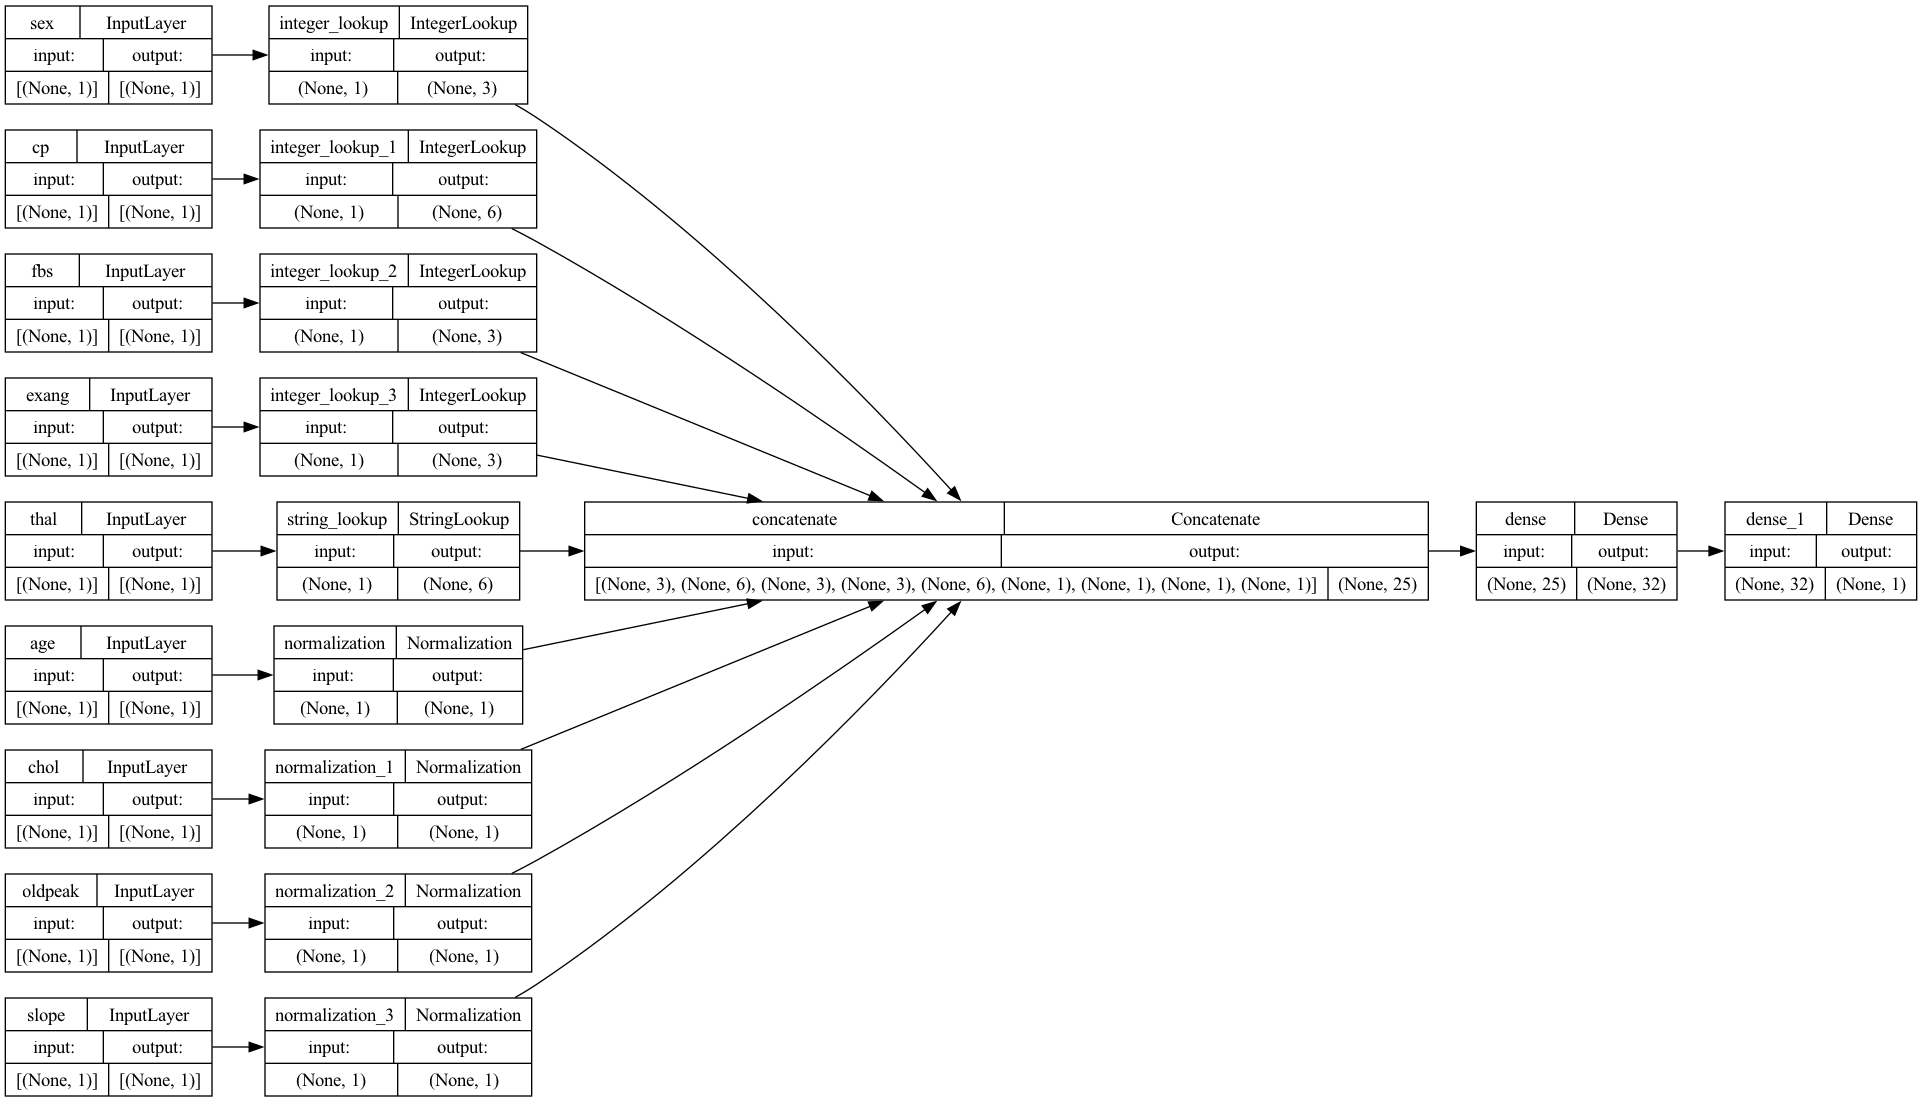

In [47]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Aseguramos que Keras use TensorFlow como backend, para asegurar que el modelo pueda usar strings como entradas

In [48]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [49]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                              

Entrenamos el modelo con los datos en el formato tf.Dataset

In [50]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 2s 80ms/step - loss: 0.7173 - accuracy: 0.4381 - precision: 0.1685 - recall: 0.3000 - roc_auc: 0.3835 - val_loss: 0.6497 - val_accuracy: 0.6458 - val_precision: 0.2222 - val_recall: 0.1667 - val_roc_auc: 0.5637
Epoch 2/50
7/7 [==============================] - 0s 6ms/step - loss: 0.6619 - accuracy: 0.6340 - precision: 0.2766 - recall: 0.2600 - roc_auc: 0.4917 - val_loss: 0.6016 - val_accuracy: 0.6875 - val_precision: 0.2857 - val_recall: 0.1667 - val_roc_auc: 0.7141
Epoch 3/50
7/7 [==============================] - 0s 6ms/step - loss: 0.6192 - accuracy: 0.7113 - precision: 0.3929 - recall: 0.2200 - roc_auc: 0.5714 - val_loss: 0.5619 - val_accuracy: 0.7292 - val_precision: 0.4000 - val_recall: 0.1667 - val_roc_auc: 0.7894
Epoch 4/50
7/7 [==============================] - 0s 5ms/step - loss: 0.5833 - accuracy: 0.7268 - precision: 0.4348 - recall: 0.2000 - roc_auc: 0.6524 - val_loss: 0.5303 - val_accuracy: 0.7708 - val_precision: 0.6000 - 

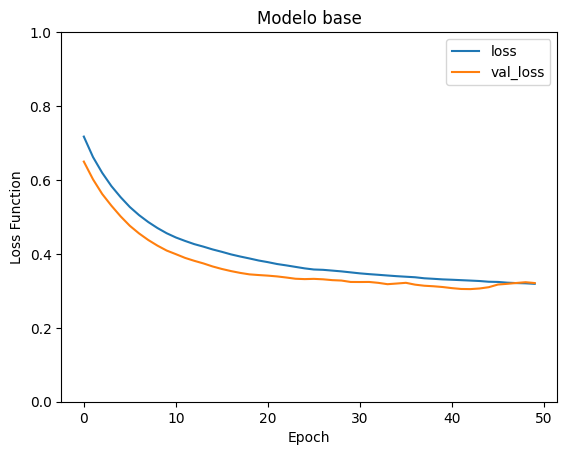

In [51]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
# plt.plot(history.history['accuracy'],label='accuracy')
# plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Modelo base")
plt.legend()

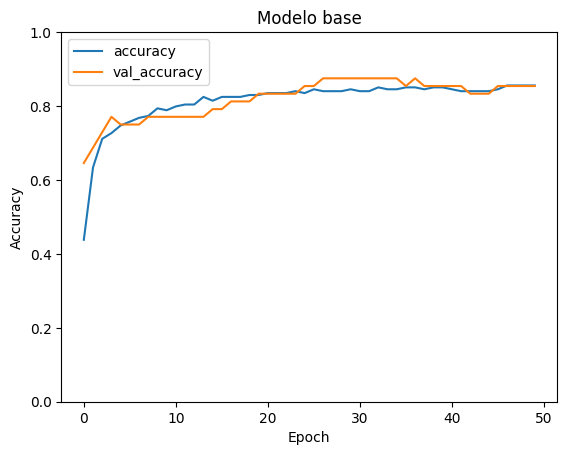

In [52]:
import matplotlib.pyplot as plt
# plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Modelo base")
plt.legend()

In [53]:
results = model.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados para modelo base")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value}")

Resultados para modelo base
loss: 0.4152015745639801
accuracy: 0.7868852615356445
precision: 0.7222222089767456
recall: 0.6190476417541504
roc_auc: 0.8982143402099609
